In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
# Конфигурация
class Config:
    batch_size = 128
    epochs = 10
    lr = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразования данных с аугментацией
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Загрузка данных
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.batch_size, shuffle=False, num_workers=4)


In [5]:


# Архитектура CNN для MNIST
class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # [B, 32, 28, 28]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 14, 14]
            
            nn.Conv2d(32, 64, 3, padding=1),  # [B, 64, 14, 14]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # [B, 64, 7, 7]
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 469/469 [00:09<00:00, 49.83it/s, loss=0.0980]


Epoch 1 Average Loss: 0.2055


Epoch 2/10: 100%|██████████| 469/469 [00:09<00:00, 47.30it/s, loss=0.0444]


Epoch 2 Average Loss: 0.0847


Epoch 3/10: 100%|██████████| 469/469 [00:10<00:00, 46.47it/s, loss=0.0756]


Epoch 3 Average Loss: 0.0694


Epoch 4/10: 100%|██████████| 469/469 [00:10<00:00, 45.31it/s, loss=0.0495]


Epoch 4 Average Loss: 0.0616


Epoch 5/10: 100%|██████████| 469/469 [00:10<00:00, 46.88it/s, loss=0.0262]


Epoch 5 Average Loss: 0.0561


Epoch 6/10: 100%|██████████| 469/469 [00:09<00:00, 49.56it/s, loss=0.0477]


Epoch 6 Average Loss: 0.0494


Epoch 7/10: 100%|██████████| 469/469 [00:09<00:00, 49.60it/s, loss=0.0335]


Epoch 7 Average Loss: 0.0448


Epoch 8/10: 100%|██████████| 469/469 [00:09<00:00, 49.25it/s, loss=0.0313]


Epoch 8 Average Loss: 0.0428


Epoch 9/10: 100%|██████████| 469/469 [00:09<00:00, 48.63it/s, loss=0.0148]


Epoch 9 Average Loss: 0.0405


Epoch 10/10: 100%|██████████| 469/469 [00:09<00:00, 48.75it/s, loss=0.0626]

Epoch 10 Average Loss: 0.0375



Test Accuracy: 99.21%


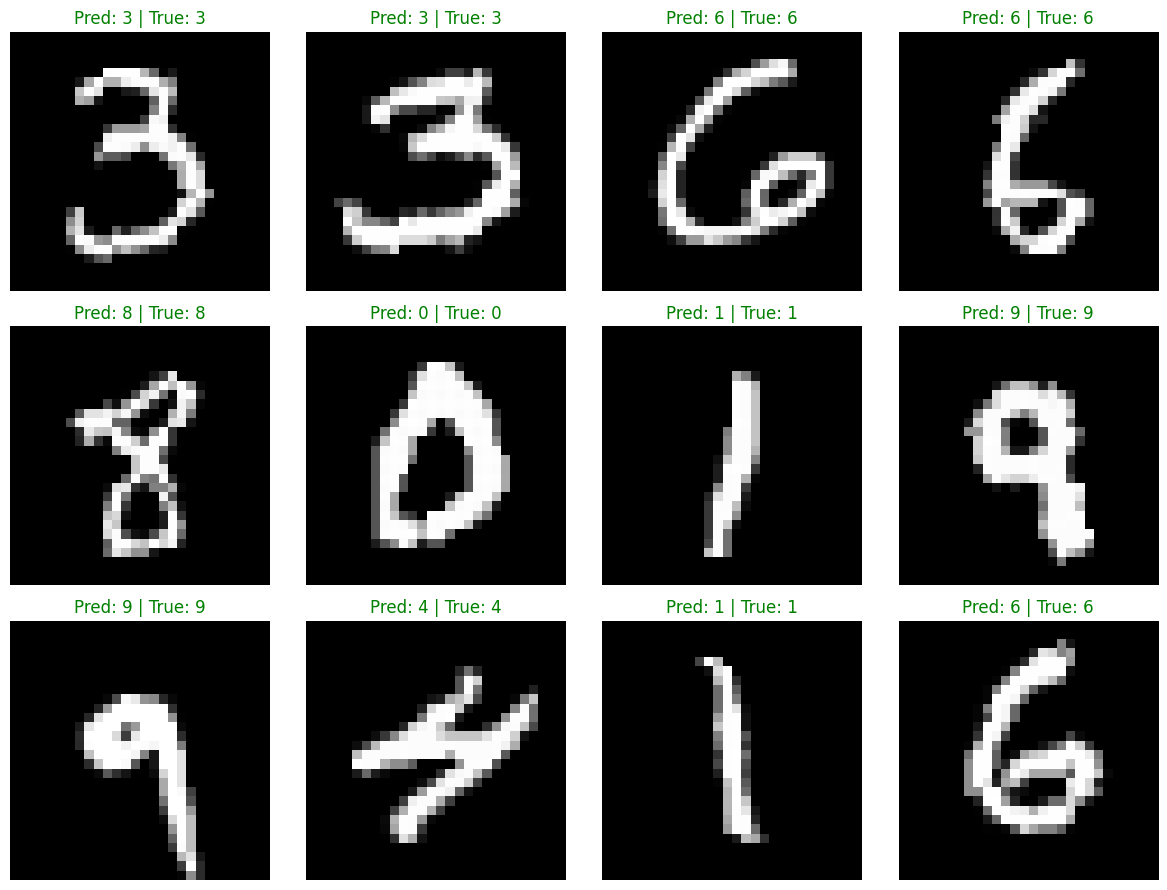

In [2]:


# Инициализация модели
model = MNISTCNN().to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()

# Обучение
for epoch in range(Config.epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{Config.epochs}')
    
    for images, labels in progress_bar:
        images, labels = images.to(Config.device), labels.to(Config.device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    print(f'Epoch {epoch+1} Average Loss: {total_loss/len(trainloader):.4f}')

# Оценка точности
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(Config.device), labels.to(Config.device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nTest Accuracy: {100 * correct / total:.2f}%')

# Визуализация
def plot_predictions(num_images=12):
    model.eval()
    indices = np.random.choice(len(testset), num_images)
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    
    for idx, ax in zip(indices, axes.flat):
        image, label = testset[idx]
        img = image.squeeze().numpy()
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(Config.device))
            prediction = torch.argmax(output).item()
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pred: {prediction} | True: {label}', 
                     color='green' if prediction == label else 'red')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_predictions()